# Read & Load Data 

In [ ]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

In [27]:
df = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
t_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [28]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

# Preprocessing 

In [29]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop(['cc_num', 'trans_date_trans_time', 'first', 'last', 'dob', 'street', 'trans_num', 'unix_time', 'merchant'], axis=1)
    
    # Handle outliers for 'amt' and 'city_pop'
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        if col in ['amt', 'city_pop']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Encode categorical variables
    label_encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Convert gender to binary
    df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
    
    # Normalize numerical features
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_scaled



In [30]:
df_preprocessed = preprocess_data(df)
t_df_preprocessed = preprocess_data(t_df)

print(df_preprocessed.head())
print(t_df_preprocessed.head())

     Unnamed: 0  category       amt  gender      city  state       zip  \
0  0.000000e+00  0.615385  0.020637     0.0  0.589026   0.54  0.278069   
1  7.712039e-07  0.307692  0.552203     0.0  0.685330   0.94  0.993677   
2  1.542408e-06  0.000000  1.000000     0.0  0.524076   0.26  0.832217   
3  2.313612e-06  0.153846  0.228720     0.0  0.094065   0.52  0.592483   
4  3.084815e-06  0.692308  0.212917     0.0  0.241881   0.90  0.235227   

        lat      long  city_pop       job  merch_lat  merch_long  is_fraud  
0  0.343968  0.864638  0.069884  0.750507   0.350302    0.848602       0.0  
1  0.618450  0.485682  0.002536  0.868154   0.621488    0.486208       0.0  
2  0.474727  0.546553  0.083148  0.622718   0.497559    0.546697       0.0  
3  0.561509  0.548070  0.038565  0.665314   0.577663    0.542619       0.0  
4  0.394153  0.882190  0.001530  0.235294   0.405244    0.882857       0.0  
   Unnamed: 0  category       amt  gender      city     state       zip  \
0    0.000000  0.7

In [31]:
df_preprocessed.isna().sum()   

Unnamed: 0    0
category      0
amt           0
gender        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

In [32]:
# check coulmns type and missing values and shape of data 
df_preprocessed.info()   
# this mean nulls = zero 
# we need to convert any object to numrical value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1296675 non-null  float64
 1   category    1296675 non-null  float64
 2   amt         1296675 non-null  float64
 3   gender      1296675 non-null  float64
 4   city        1296675 non-null  float64
 5   state       1296675 non-null  float64
 6   zip         1296675 non-null  float64
 7   lat         1296675 non-null  float64
 8   long        1296675 non-null  float64
 9   city_pop    1296675 non-null  float64
 10  job         1296675 non-null  float64
 11  merch_lat   1296675 non-null  float64
 12  merch_long  1296675 non-null  float64
 13  is_fraud    1296675 non-null  float64
dtypes: float64(14)
memory usage: 138.5 MB


In [33]:
# get statistics on numrical columns ( int or float ) 
df_preprocessed.describe()

,Unnamed: 0,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1296675.0,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,5.000000e-01,4.790606e-01,2.956181e-01,0.0,4.986151e-01,5.335456e-01,4.825495e-01,3.966580e-01,7.720469e-01,2.725721e-01,5.094796e-01,4.024042e-01,7.665916e-01,5.788652e-03
std,2.886755e-01,3.010341e-01,2.762236e-01,0.0,2.895858e-01,2.866196e-01,2.729556e-01,1.087684e-01,1.407982e-01,3.856712e-01,2.841975e-01,1.053945e-01,1.380971e-01,7.586269e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500000e-01,2.307692e-01,4.496426e-02,0.0,2.508399e-01,3.000000e-01,2.535371e-01,3.127188e-01,7.047983e-01,1.449202e-02,2.657201e-01,3.239477e-01,6.996964e-01,0.000000e+00
50%,5.000000e-01,4.615385e-01,2.418194e-01,0.0,4.916013e-01,5.600000e-01,4.761890e-01,4.141584e-01,8.001821e-01,4.897097e-02,5.091278e-01,4.194896e-01,7.945505e-01,0.000000e+00
75%,7.500000e-01,7.692308e-01,4.269786e-01,0.0,7.581187e-01,7.600000e-01,7.184398e-01,4.695754e-01,8.750773e-01,4.086952e-01,7.586207e-01,4.729415e-01,8.667685e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [34]:
print(df_preprocessed.duplicated().sum())


0


In [35]:
df_preprocessed.dtypes

Unnamed: 0    float64
category      float64
amt           float64
gender        float64
city          float64
state         float64
zip           float64
lat           float64
long          float64
city_pop      float64
job           float64
merch_lat     float64
merch_long    float64
is_fraud      float64
dtype: object

In [36]:
X_train = df_preprocessed.drop('is_fraud', axis=1)
y_train = df_preprocessed['is_fraud']
X_test = t_df_preprocessed.drop('is_fraud', axis=1)
y_test = t_df_preprocessed['is_fraud']

# EDA and Visualizations

### class Imbalance

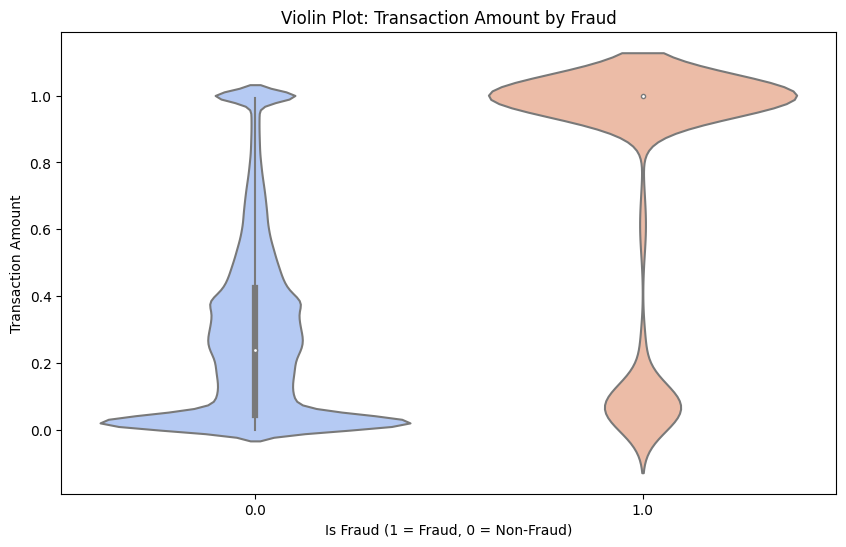

In [37]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_fraud', y='amt', data=df_preprocessed, palette='coolwarm')
plt.title('Violin Plot: Transaction Amount by Fraud')
plt.xlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.ylabel('Transaction Amount')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


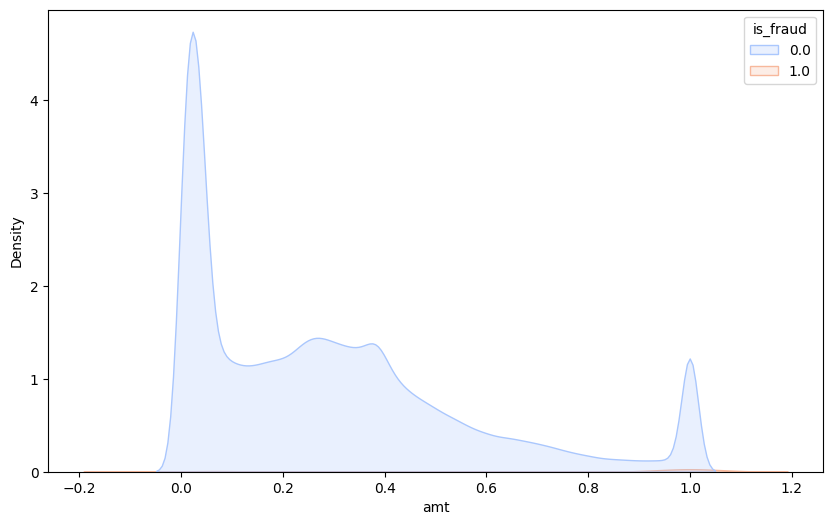

In [38]:
# KDE Plot with Clear Labels 
plt.figure(figsize=(10, 6))
kde_plot = sns.kdeplot(data=df_preprocessed, 
                       x='amt', 
                       hue='is_fraud', 
                       palette='coolwarm', 
                       fill=True)

### Geospatial Analysis

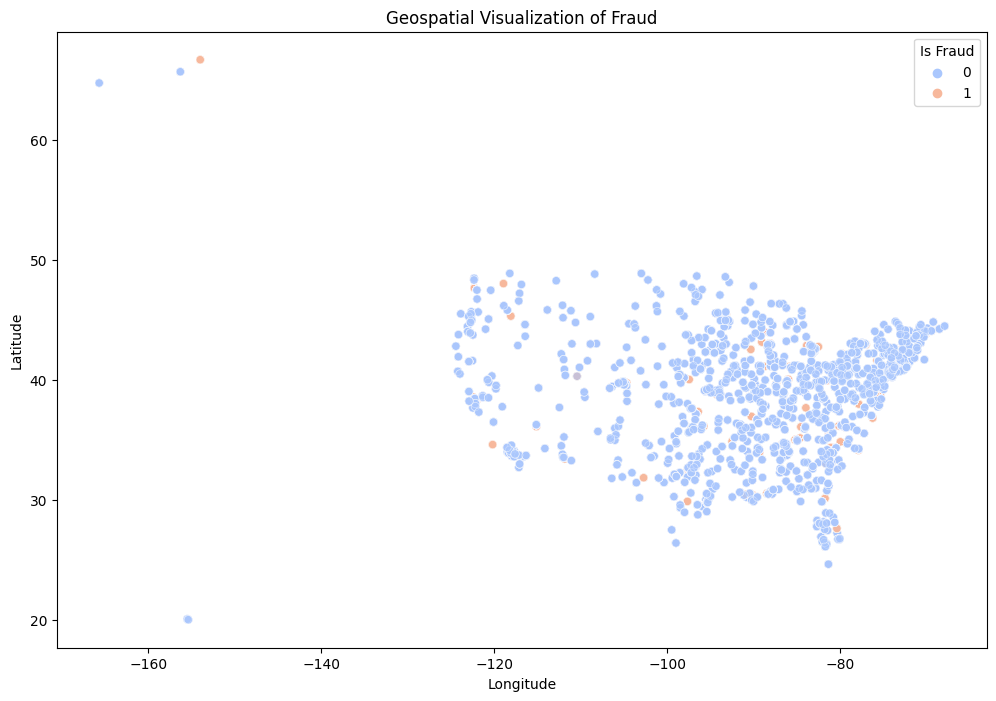

In [39]:
# Plot fraud incidents on a map
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat', hue='is_fraud', data=df, palette='coolwarm', alpha=0.6)
plt.title('Geospatial Visualization of Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Temporal Analysis

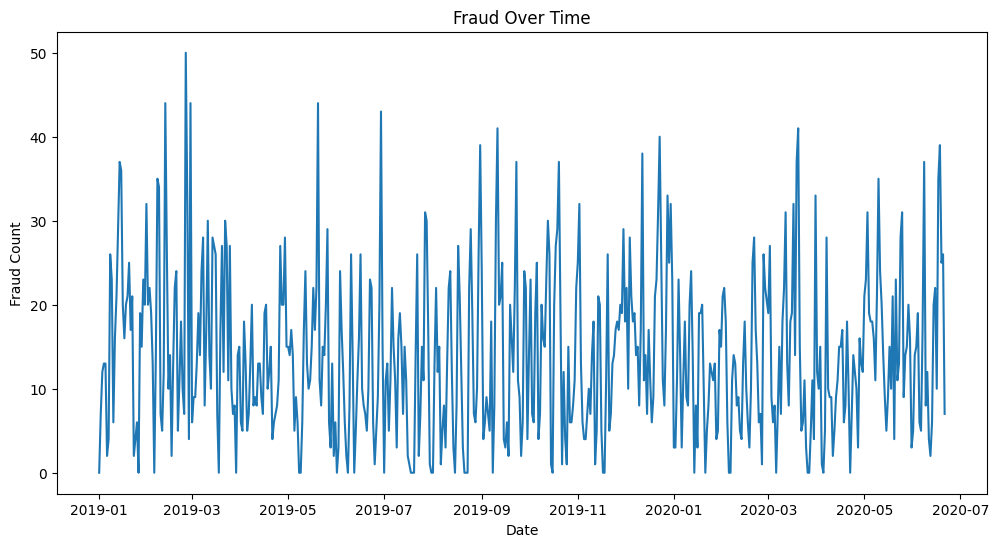

In [40]:
# Convert transaction time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Group by date and calculate fraud count
fraud_over_time = df.groupby(df['trans_date_trans_time'].dt.date)['is_fraud'].sum()

# Plot time series
plt.figure(figsize=(12, 6))
fraud_over_time.plot()
plt.title('Fraud Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Count')
plt.show()

### Features 

#### Transaction Amount, City Population, and Fraud

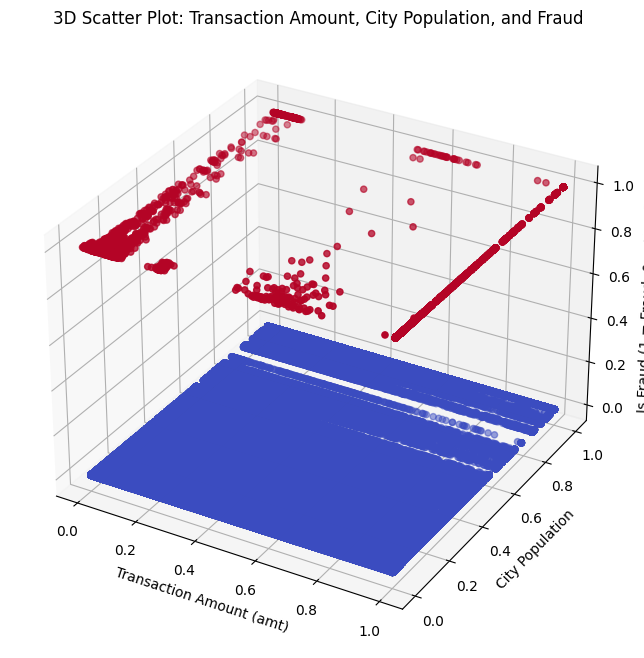

In [41]:
# 7. 3D Scatter Plot: Transaction Amount, City Population, and Fraud
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    df_preprocessed['amt'],
    df_preprocessed['city_pop'],
    df_preprocessed['is_fraud'],
    c=df_preprocessed['is_fraud'],
    cmap='coolwarm',
    s=20
)

# Labels
ax.set_xlabel('Transaction Amount (amt)')
ax.set_ylabel('City Population')
ax.set_zlabel('Is Fraud (1 = Fraud, 0 = Non-Fraud)')
plt.title('3D Scatter Plot: Transaction Amount, City Population, and Fraud')
plt.show()

#### City Population

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


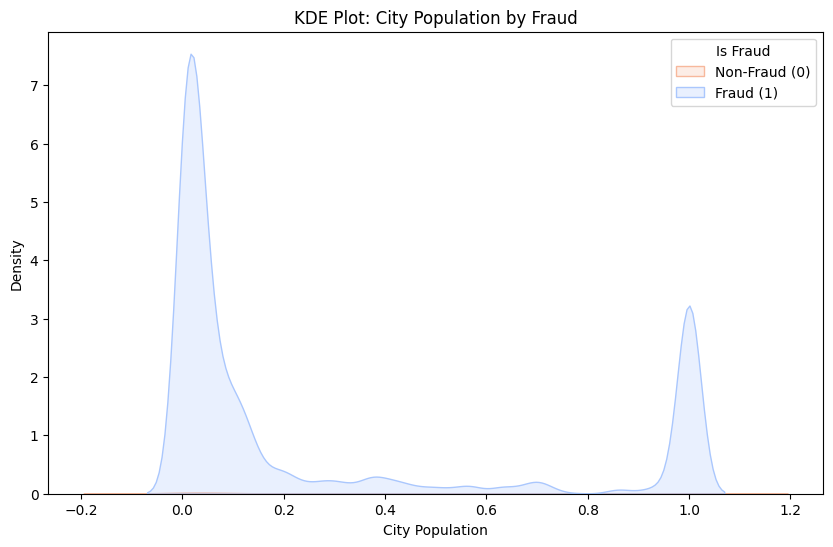

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_preprocessed, x='city_pop', hue='is_fraud', palette='coolwarm', fill=True)
plt.title('KDE Plot: City Population by Fraud')
plt.xlabel('City Population')
plt.ylabel('Density')
plt.legend(title='Is Fraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

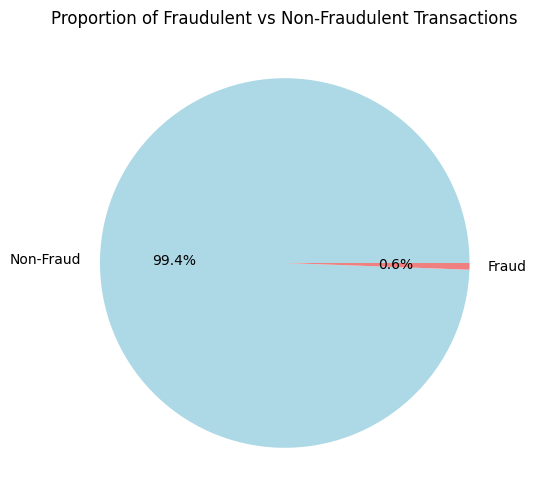

In [43]:
# Calculate fraud proportion
fraud_proportion = df['is_fraud'].value_counts(normalize=True)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


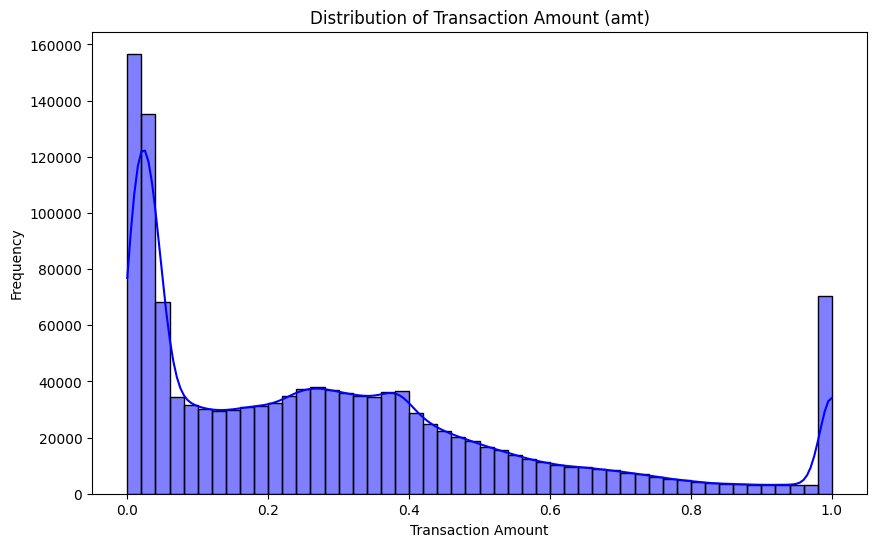

In [44]:

# Distribution of Transaction Amount (amt)
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['amt'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amount (amt)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


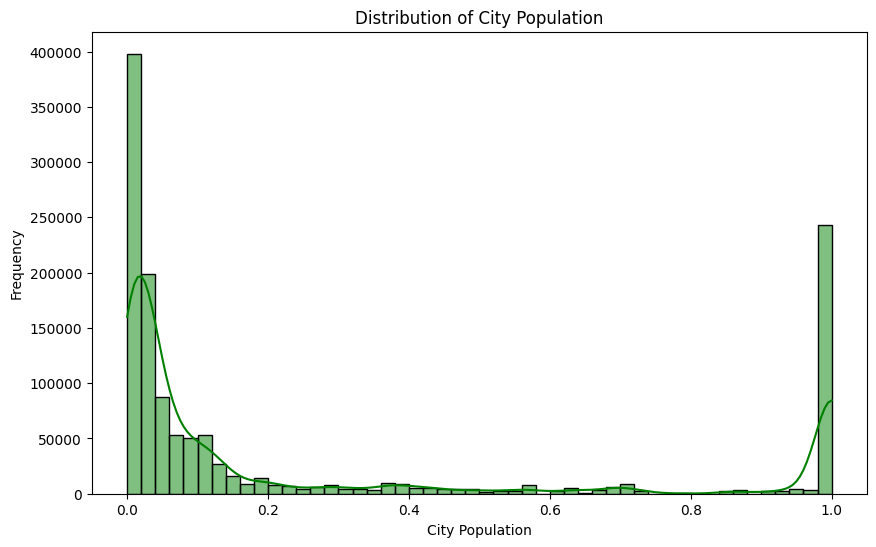

In [45]:

# Distribution of City Population
plt.figure(figsize=(10, 6))
sns.histplot(df_preprocessed['city_pop'], bins=50, kde=True, color='green')
plt.title('Distribution of City Population')
plt.xlabel('City Population')
plt.ylabel('Frequency')
plt.show()


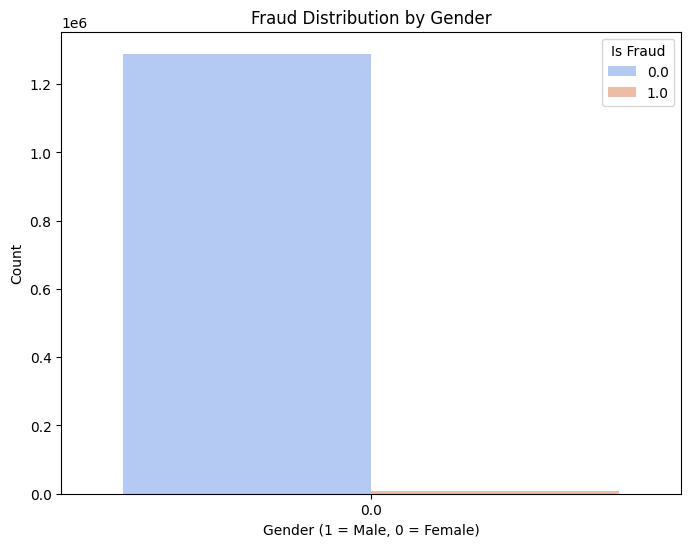

In [46]:

# Fraud Distribution by Gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='is_fraud', data=df_preprocessed, palette='coolwarm')
plt.title('Fraud Distribution by Gender')
plt.xlabel('Gender (1 = Male, 0 = Female)')
plt.ylabel('Count')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

### Correlation Matrix 

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


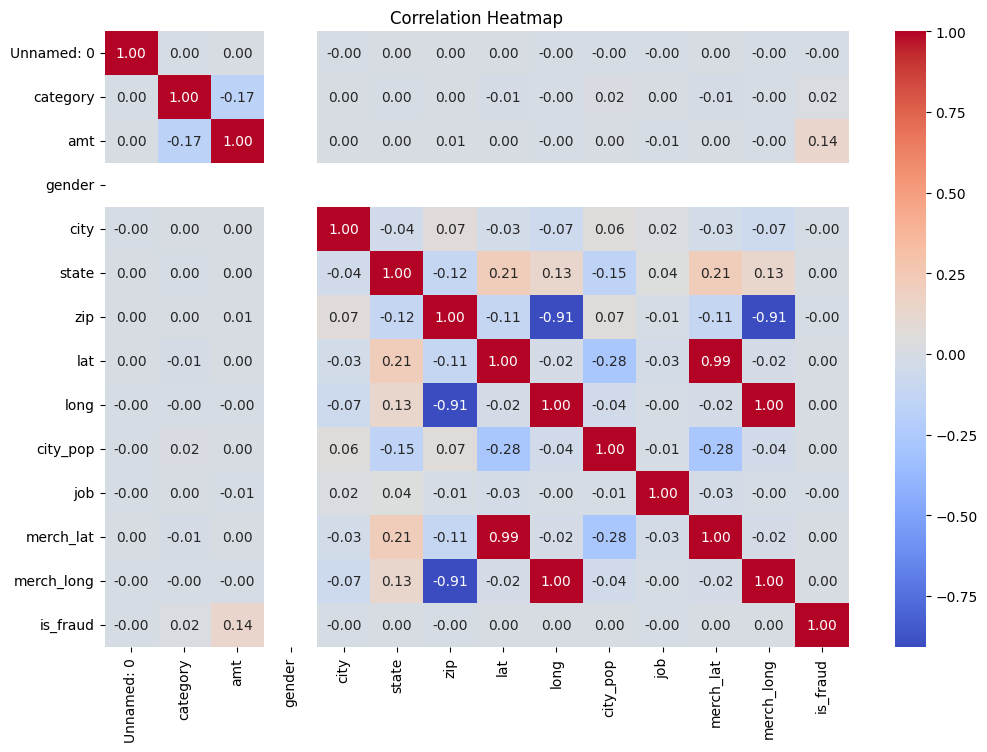

In [47]:

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_preprocessed.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


# Machine Learning Models 

## Isolation Forest
Isolates anomalies by randomly splitting the data.

In [51]:
iso_forest = IsolationForest(contamination=0.02, random_state=42)

# Train and predict on training set
iso_forest.fit(X_train)
train_pred = iso_forest.predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)  # Convert -1 (outlier) to 1, 0 (inlier) to 0

# Predict on test set
test_pred = iso_forest.predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("Isolation Forest - Train Accuracy: {:.4f}".format(train_accuracy))
print("Isolation Forest - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest - Train Accuracy: 0.9750
Isolation Forest - Test Accuracy: 0.9753
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    553574
         1.0       0.01      0.08      0.02      2145

    accuracy                           0.98    555719
   macro avg       0.51      0.53      0.51    555719
weighted avg       0.99      0.98      0.98    555719



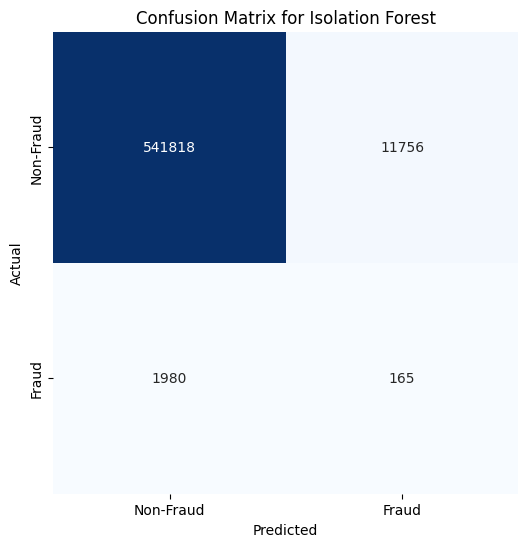

In [52]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

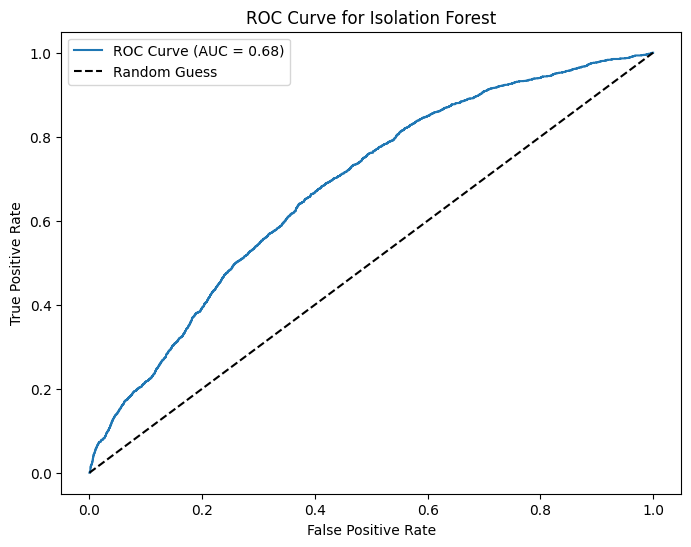

In [53]:
# Get anomaly scores from Isolation Forest
test_scores = iso_forest.decision_function(X_test)  
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, -test_scores) 
auc_score = roc_auc_score(y_test, -test_scores) 
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Isolation Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Local Outlier Factor (LOF)
Compares local density of a point to its neighbors.

In [54]:
lof = LocalOutlierFactor(contamination=0.02)

# Predict on training set
train_pred = lof.fit_predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)

# Predict on test set
test_pred = lof.fit_predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("Local Outlier Factor (LOF) - Train Accuracy: {:.4f}".format(train_accuracy))
print("Local Outlier Factor (LOF) - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

Local Outlier Factor (LOF) - Train Accuracy: 0.9759
Local Outlier Factor (LOF) - Test Accuracy: 0.9768
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    553574
         1.0       0.02      0.08      0.03      2145

    accuracy                           0.98    555719
   macro avg       0.51      0.53      0.51    555719
weighted avg       0.99      0.98      0.98    555719



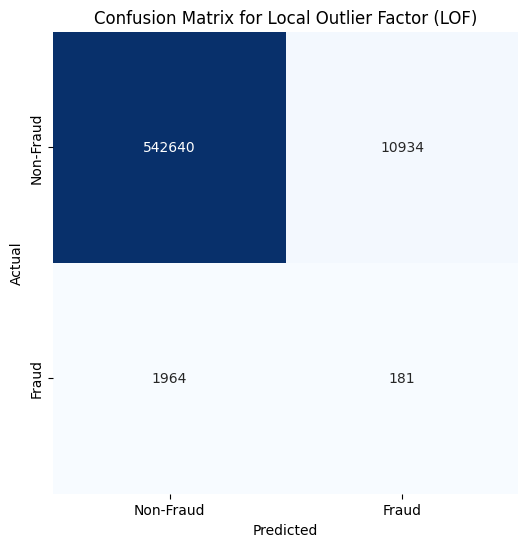

In [55]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Local Outlier Factor (LOF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

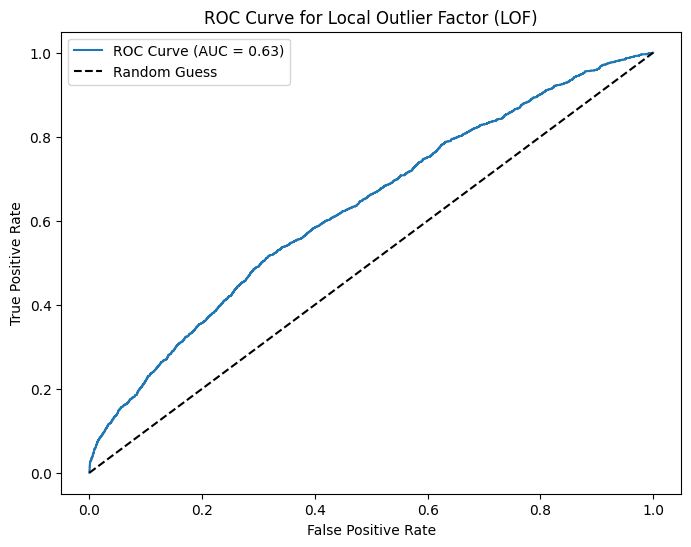

In [56]:
# Get negative outlier factor scores for the test set
test_scores = -lof.negative_outlier_factor_ 
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_scores)
auc_score = roc_auc_score(y_test, test_scores)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Local Outlier Factor (LOF)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## DBSCAN
Groups data into clusters; points not in any cluster are outliers.

In [76]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
# Predict on training set
train_pred = dbscan.fit_predict(X_train)
train_pred = np.where(train_pred == -1, 1, 0)

# Predict on test set
test_pred = dbscan.fit_predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("DBSCAN - Train Accuracy: {:.4f}".format(train_accuracy))
print("DBSCAN - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

DBSCAN - Train Accuracy: 0.9323
DBSCAN - Test Accuracy: 0.8159
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90    553574
         1.0       0.02      0.74      0.03      2145

    accuracy                           0.82    555719
   macro avg       0.51      0.78      0.46    555719
weighted avg       0.99      0.82      0.89    555719



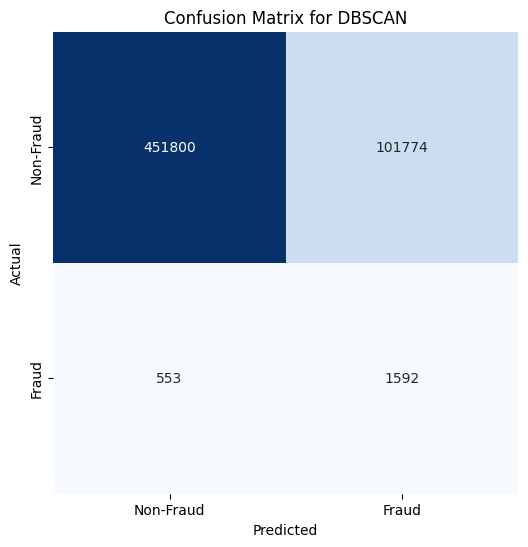

In [77]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for DBSCAN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

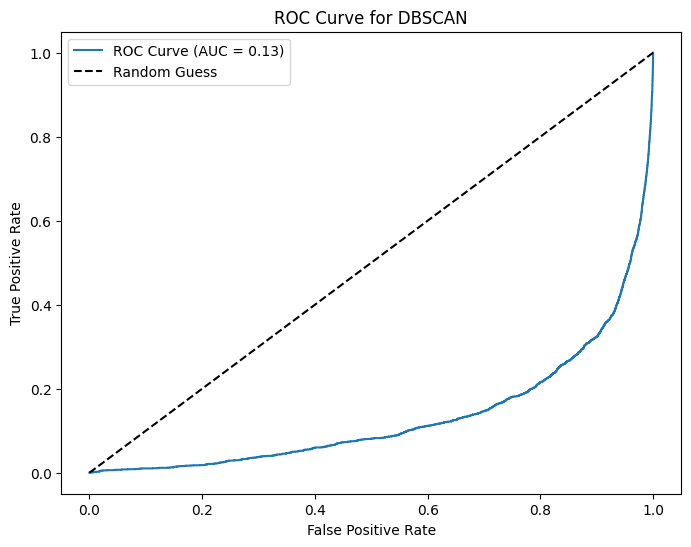

In [78]:
# Calculate the distance to the nearest core point
from sklearn.neighbors import NearestNeighbors
# Fit NearestNeighbors on the training set
nbrs = NearestNeighbors(n_neighbors=10).fit(X_train)
# Calculate distances for the test set
distances, _ = nbrs.kneighbors(X_test)
test_scores = -np.mean(distances, axis=1)  # Use negative distances as anomaly scores
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, test_scores)
auc_score = roc_auc_score(y_test, test_scores)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for DBSCAN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Deep Learning Models 

## Autoencoders
 learning to reconstruct normal data. Anomalies are detected based on high reconstruction errors.

In [63]:
input_dim = X_train.shape[1]

# Encoder
encoder_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation="relu")(encoder_input)
encoded = layers.Dense(4, activation="relu")(encoded)

# Decoder
decoded = layers.Dense(8, activation="relu")(encoded)
decoded = layers.Dense(input_dim, activation="sigmoid")(decoded)

# Define autoencoder model
autoencoder = models.Model(inputs=encoder_input, outputs=decoded)

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Compute reconstruction errors
train_reconstructed = autoencoder.predict(X_train)
train_mse = np.mean(np.power(X_train - train_reconstructed, 2), axis=1)

test_reconstructed = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_reconstructed, 2), axis=1)

# Set threshold for anomaly detection (95th percentile of training MSE)
threshold = np.percentile(train_mse, 95)

# Predict anomalies
train_pred = (train_mse > threshold).astype(int)
test_pred = (test_mse > threshold).astype(int)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

# Print results
print("Autoencoder - Train Accuracy: {:.4f}".format(train_accuracy))
print("Autoencoder - Test Accuracy: {:.4f}".format(test_accuracy))
print("Classification Report for Test Set:")
print(classification_report(y_test, test_pred))

Epoch 1/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0364 - val_loss: 0.0262
Epoch 2/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - loss: 0.0259 - val_loss: 0.0253
Epoch 3/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0247 - val_loss: 0.0242
Epoch 4/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 5/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 6/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.0238 - val_loss: 0.0239
Epoch 7/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0237 - val_loss: 0.0238
Epoch 8/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 9/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.0236 - val_loss: 0.0237
Epoch 10/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0236 - val_loss: 0.0237
Epoch 11/20
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0236 - val_loss: 0.02

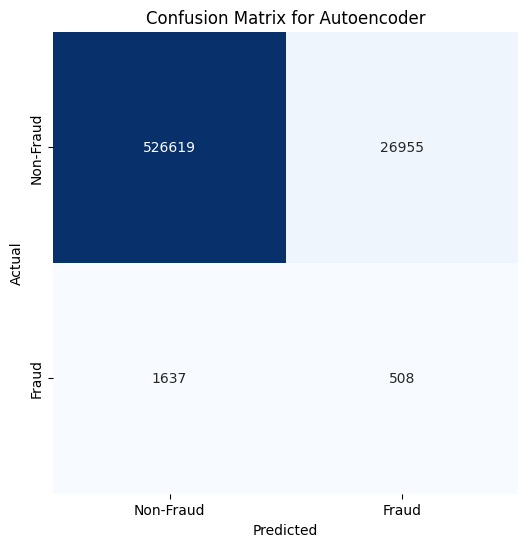

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## One-Class Neural Networks (OC-NN)
 Learning a boundary around normal data. Anomalies are detected based on deviations from this boundary.

In [ ]:
# Define input dimension
input_dim =  X_train.shape[1]

# Define the One-Class Neural Network (OC-NN)
inputs = Input(shape=(input_dim,))
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

oc_nn = Model(inputs, outputs)
oc_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = oc_nn.fit( X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = oc_nn.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9939 - loss: 0.0320 - val_accuracy: 0.9941 - val_loss: 0.0275
Epoch 2/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9943 - loss: 0.0257 - val_accuracy: 0.9941 - val_loss: 0.0249
Epoch 3/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9941 - loss: 0.0248 - val_accuracy: 0.9941 - val_loss: 0.0237
Epoch 4/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9944 - loss: 0.0225 - val_accuracy: 0.9941 - val_loss: 0.0239
Epoch 5/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9946 - loss: 0.0223 - val_accuracy: 0.9945 - val_loss: 0.0220
Epoch 6/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9947 - loss: 0.0211 - val_accuracy: 0.9944 - val_loss: 0.0225
Epoch 7/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 0.9948 - loss: 0.0207 - val_accuracy: 0.9947 - val_loss: 0.0238
Epoch 8/20
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - accuracy: 

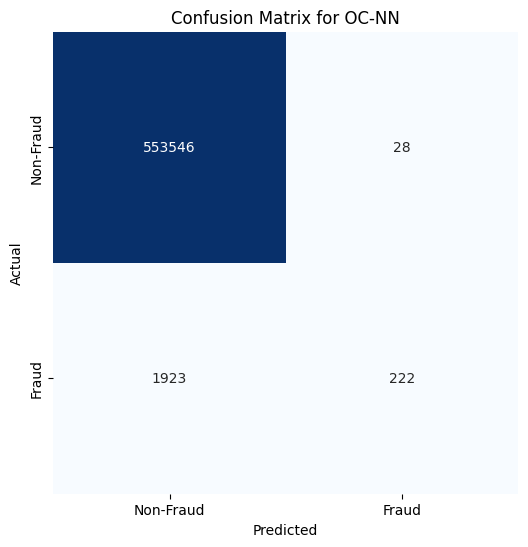

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    553574
       Fraud       0.89      0.10      0.19      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.55      0.59    555719
weighted avg       1.00      1.00      1.00    555719



In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for OC-NN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

## Deep Support Vector Data Description (Deep SVDD)
Learning a compact hypersphere around normal data. Anomalies are detected based on their distance from the hypersphere center.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train, y_test are already defined

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define input dimension
input_dim = X_train.shape[1]

# Define the Deep SVDD model with increased capacity and dropout
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)  # Increased neurons
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)  # Additional layer
x = Dropout(0.5)(x)  # Dropout for regularization
outputs = Dense(1, activation='linear')(x)

deep_svdd = Model(inputs, outputs)

# Compile the model with a different loss function and learning rate
optimizer = Adam(learning_rate=0.0001)
deep_svdd.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model without early stopping
history = deep_svdd.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_scores = deep_svdd.predict(X_test)

# Set a lower threshold for anomaly detection (e.g., 90th percentile)
train_scores = deep_svdd.predict(X_train)
threshold = np.percentile(train_scores, 90)  # Lower threshold to reduce false negatives

# Predict anomalies
test_pred = (test_scores > threshold).astype(int)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step - loss: 0.8836 - val_loss: 0.9260
Epoch 2/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.8447 - val_loss: 0.9258
Epoch 3/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 0.8446 - val_loss: 0.9256
Epoch 4/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.8446 - val_loss: 0.9257
Epoch 5/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.8449 - val_loss: 0.9258
Epoch 6/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 0.8448 - val_loss: 0.9256
Epoch 7/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.8450 - val_loss: 0.9256
Epoch 8/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 0.8449 - val_loss: 0.9257
Epoch 9/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 0.8448 - val_loss: 0.9257
Epoch 10/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 0.8434 - val_loss: 0.9257
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/st

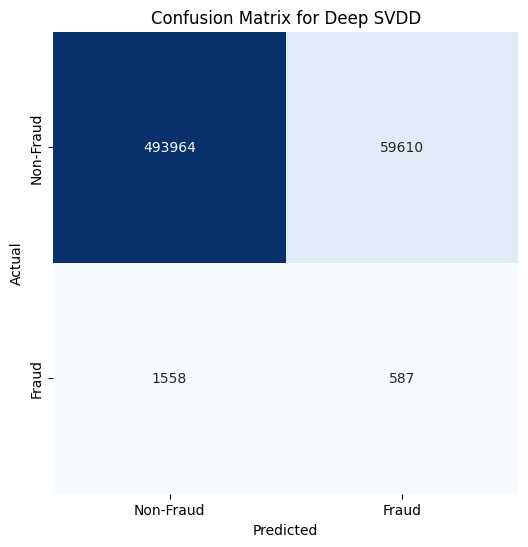

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.89      0.94    553574
       Fraud       0.01      0.27      0.02      2145

    accuracy                           0.89    555719
   macro avg       0.50      0.58      0.48    555719
weighted avg       0.99      0.89      0.94    555719



In [68]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Deep SVDD')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, test_pred, target_names=['Non-Fraud', 'Fraud']))

# visualize to compare Models  

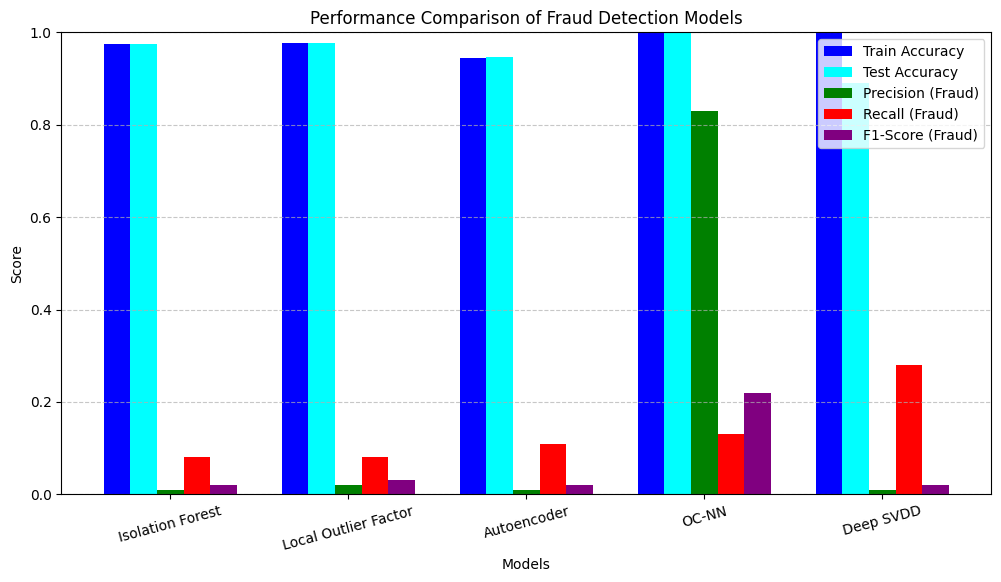

In [ ]:

# Model names
models = ["Isolation Forest", "Local Outlier Factor", "Autoencoder", "OC-NN", "Deep SVDD"]

# Accuracy scores
train_accuracy = [0.9750, 0.9759, 0.9453, 1.00, 1.00]
test_accuracy = [0.9753, 0.9768, 0.9461, 1.00, 0.89]

# Precision scores (Fraud class)
precision = [0.01, 0.02, 0.01, 0.83, 0.01]

# Recall scores (Fraud class)
recall = [0.08, 0.08, 0.11, 0.13, 0.28]

# F1-score (Fraud class)
f1_score = [0.02, 0.03, 0.02, 0.22, 0.02]

# Bar chart settings
bar_width = 0.15
index = np.arange(len(models))

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.bar(index, train_accuracy, bar_width, label='Train Accuracy', color='blue')
plt.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy', color='cyan')
plt.bar(index + 2 * bar_width, precision, bar_width, label='Precision (Fraud)', color='green')
plt.bar(index + 3 * bar_width, recall, bar_width, label='Recall (Fraud)', color='red')
plt.bar(index + 4 * bar_width, f1_score, bar_width, label='F1-Score (Fraud)', color='purple')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Comparison of Fraud Detection Models')
plt.xticks(index + 2 * bar_width, models, rotation=15)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###  ROC Curves


17367/17367 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


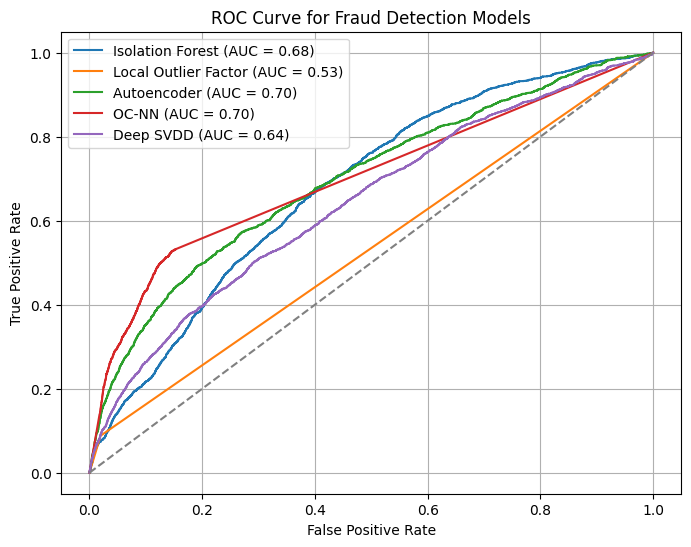

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


In [ ]:
# === Train Anomaly Detection Models ===
iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(X_train)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof.fit(X_train)

# === Get Model Scores (Probabilities) for ROC Curve ===
isolation_forest_scores = -iso_forest.decision_function(X_test)  # Higher values = More anomalous
lof_scores = -lof.fit_predict(X_test)  # Convert LOF predictions to scores
autoencoder_scores = test_mse  # MSE values from autoencoder reconstruction error
oc_nn_scores = oc_nn.predict(X_test).flatten()  # Assuming it gives probability values
deep_svdd_scores = deep_svdd.predict(X_test).flatten()  # Use raw scores

# Normalize LOF & Deep SVDD Scores for ROC Curve
lof_scores = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())
deep_svdd_scores = (deep_svdd_scores - deep_svdd_scores.min()) / (deep_svdd_scores.max() - deep_svdd_scores.min())

# Store All Model Scores
models = {
    "Isolation Forest": isolation_forest_scores,
    "Local Outlier Factor": lof_scores,
    "Autoencoder": autoencoder_scores,
    "OC-NN": oc_nn_scores,
    "Deep SVDD": deep_svdd_scores
}

# === Plot ROC Curves ===
plt.figure(figsize=(8, 6))
for model_name, y_scores in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Detection Models')
plt.legend()
plt.grid(True)
plt.show()

# === Convert Scores to Binary Predictions for Confusion Matrices ===
threshold = 0.5  # Adjust threshold based on performance

isolation_forest_predictions = (iso_forest.decision_function(X_test) < 0).astype(int)
lof_predictions = (lof.fit_predict(X_test) == -1).astype(int)  # LOF outputs -1 for anomalies
autoencoder_predictions = (test_mse > threshold).astype(int)  # Adjust threshold
oc_nn_predictions = (oc_nn.predict(X_test) > threshold).astype(int)
deep_svdd_predictions = (deep_svdd.predict(X_test) > threshold).astype(int)

# Store Model Predictions
models_predictions = {
    "Isolation Forest": isolation_forest_predictions,
    "Local Outlier Factor": lof_predictions,
    "Autoencoder": autoencoder_predictions,
    "OC-NN": oc_nn_predictions,
    "Deep SVDD": deep_svdd_predictions
}



### Precision-Recall Curves


17367/17367 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


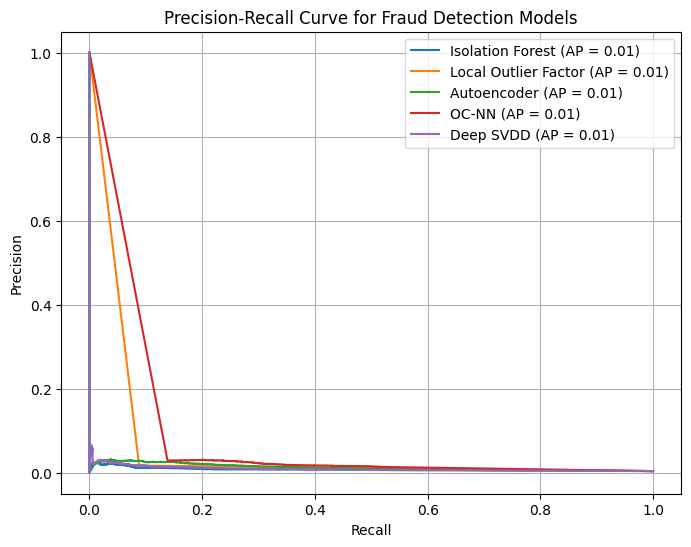

In [ ]:
# === Train Anomaly Detection Models ===
iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(X_train)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof.fit(X_train)

# === Get Model Scores for Precision-Recall Curves ===
isolation_forest_scores = -iso_forest.decision_function(X_test)  # Higher = More anomalous
lof_scores = -lof.fit_predict(X_test)  # Convert LOF predictions to scores
autoencoder_scores = test_mse  # MSE values from autoencoder reconstruction error
oc_nn_scores = oc_nn.predict(X_test).flatten()  # Assuming probability values
deep_svdd_scores = deep_svdd.predict(X_test).flatten()  # Use raw scores

# Normalize LOF & Deep SVDD Scores for PR Curve
lof_scores = (lof_scores - lof_scores.min()) / (lof_scores.max() - lof_scores.min())
deep_svdd_scores = (deep_svdd_scores - deep_svdd_scores.min()) / (deep_svdd_scores.max() - deep_svdd_scores.min())

# Store All Model Scores
models = {
    "Isolation Forest": isolation_forest_scores,
    "Local Outlier Factor": lof_scores,
    "Autoencoder": autoencoder_scores,
    "OC-NN": oc_nn_scores,
    "Deep SVDD": deep_svdd_scores
}

# === Plot Precision-Recall Curves ===
plt.figure(figsize=(8, 6))

for model_name, y_scores in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{model_name} (AP = {avg_precision:.2f})")

# Final plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Fraud Detection Models')
plt.legend()
plt.grid(True)
plt.show()


### The End 